Step-By-Step Implementation of a Transformer

In [1]:
!pip install torch torchvision torchaudio


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import math
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    """Generates sinusoidal positional encodings for sequence positions."""

    DEFAULT_BASE_FREQUENCY = 10000.0

    def __init__(self, d_model: int, max_sequence_length: int = 512):
        super().__init__()
        self.d_model = d_model
        self._register_positional_buffer(max_sequence_length)

    def _register_positional_buffer(self, max_sequence_length: int) -> None:
        """Pre-compute and register positional encodings as a buffer."""
        position = torch.arange(max_sequence_length).unsqueeze(1).float()
        div_term = self._compute_frequency_bands()

        encoding = torch.zeros(max_sequence_length, self.d_model)
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer("encoding", encoding.unsqueeze(0))

    def _compute_frequency_bands(self) -> torch.Tensor:
        """Compute exponentially decreasing frequency bands."""
        exponent = torch.arange(0, self.d_model, 2).float()
        return torch.exp(
            exponent * (-math.log(self.DEFAULT_BASE_FREQUENCY) / self.d_model)
        )

    def forward(self, sequence_length: int) -> torch.Tensor:
        return self.encoding[:, :sequence_length, :]


class EmbeddingWithProjection(nn.Module):
    """Token embedding with optional projection and positional encoding."""

    def __init__(
        self,
        vocab_size: int,
        d_embedding: int,
        d_model: int,
        max_sequence_length: int = 512,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_embedding)
        self.projection = nn.Linear(d_embedding, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_sequence_length)
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.scale_factor = math.sqrt(d_model)

    def forward(self, token_ids: torch.Tensor) -> torch.Tensor:
        """
        Args:
            token_ids: Input tensor of shape (batch_size, sequence_length) with dtype torch.long
        Returns:
            Embedded and encoded tensor of shape (batch_size, sequence_length, d_model)
        """
        self._validate_input(token_ids)

        token_embeddings = self._embed_and_scale(token_ids)
        position_encodings = self.positional_encoding(token_ids.size(1))

        combined = self.layer_norm(token_embeddings + position_encodings)
        return self.dropout(combined)

    def _validate_input(self, token_ids: torch.Tensor) -> None:
        if token_ids.dtype != torch.long:
            raise TypeError(f"Expected dtype torch.long, got {token_ids.dtype}")

    def _embed_and_scale(self, token_ids: torch.Tensor) -> torch.Tensor:
        embedded = self.embedding(token_ids)
        projected = self.projection(embedded)
        return projected * self.scale_factor

Attention Mechanism

In [3]:
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F


class MultiHeadAttention(nn.Module):
    """Scaled dot-product multi-head attention with optional weight output."""

    def __init__(
        self, d_model: int, num_heads: int, dropout: float = 0.1, bias: bool = True
    ):
        super().__init__()
        if d_model % num_heads != 0:
            raise ValueError(
                f"d_model ({d_model}) must be divisible by num_heads ({num_heads})"
            )

        self.num_heads = num_heads
        self.d_head = d_model // num_heads
        self.scale = 1.0 / math.sqrt(self.d_head)

        self.q_proj = nn.Linear(d_model, d_model, bias=bias)
        self.k_proj = nn.Linear(d_model, d_model, bias=bias)
        self.v_proj = nn.Linear(d_model, d_model, bias=bias)
        self.output_proj = nn.Linear(d_model, d_model, bias=bias)
        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self,
        query: torch.Tensor,
        key_value_states: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        return_attention_weights: bool = False,  # New parameter
    ):
        source = key_value_states if key_value_states is not None else query

        q = self._split_heads(self.q_proj(query))
        k = self._split_heads(self.k_proj(source))
        v = self._split_heads(self.v_proj(source))

        context, weights = self._compute_attention(q, k, v, attention_mask)
        output = self.output_proj(self._merge_heads(context))

        if return_attention_weights:
            return output, weights
        return output

    def _split_heads(self, tensor: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = tensor.size()
        return tensor.view(batch_size, seq_len, self.num_heads, self.d_head).transpose(
            1, 2
        )

    def _merge_heads(self, tensor: torch.Tensor) -> torch.Tensor:
        batch_size, _, seq_len, _ = tensor.size()
        return tensor.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)

    def _compute_attention(self, query, key, value, mask):
        scores = torch.matmul(query, key.transpose(-1, -2)) * self.scale
        if mask is not None:
            scores = scores + mask
        weights = F.softmax(scores, dim=-1)
        context = torch.matmul(self.dropout(weights), value)
        return context, weights  # Always return both

Feed-Forward Neural Network

In [4]:
from typing import Callable

import torch
import torch.nn as nn


class FeedForward(nn.Module):
    """Position-wise feed-forward network: FFN(x) = activation(xW₁ + b₁)W₂ + b₂"""

    def __init__(
        self,
        d_model: int,
        d_ff: int,
        dropout: float = 0.0,
        activation: Callable[[torch.Tensor], torch.Tensor] = F.relu,
    ):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
        Returns:
            Output tensor of shape (batch_size, seq_len, d_model)
        """
        return self.linear2(self.dropout(self.activation(self.linear1(x))))

Transformer Decoder

In [5]:
from typing import Optional

import torch
import torch.nn as nn


class DecoderLayer(nn.Module):
    """Single transformer decoder layer with self-attention, cross-attention, and feed-forward."""

    def __init__(
        self,
        d_model: int,
        num_heads: int,
        d_ff: int,
        dropout: float = 0.1,
        bias: bool = True,
        pre_norm: bool = False,
    ):
        super().__init__()
        self.pre_norm = pre_norm

        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout, bias)
        self.cross_attention = MultiHeadAttention(d_model, num_heads, dropout, bias)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        self.norm_self_attn = nn.LayerNorm(d_model)
        self.norm_cross_attn = nn.LayerNorm(d_model)
        self.norm_ffn = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        target: torch.Tensor,
        memory: torch.Tensor,
        target_mask: Optional[torch.Tensor] = None,
        memory_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        """
        Args:
            target: Decoder input (batch_size, target_seq_len, d_model)
            memory: Encoder output (batch_size, source_seq_len, d_model)
            target_mask: Causal mask for self-attention
            memory_mask: Padding mask for cross-attention
        """
        if target_mask is None:
            target_mask = self._create_causal_mask(target.size(1), target.device)

        if self.pre_norm:
            target = self._pre_norm_forward(target, memory, target_mask, memory_mask)
        else:
            target = self._post_norm_forward(target, memory, target_mask, memory_mask)

        return target

    def _post_norm_forward(
        self,
        target: torch.Tensor,
        memory: torch.Tensor,
        target_mask: torch.Tensor,
        memory_mask: Optional[torch.Tensor],
    ) -> torch.Tensor:
        """Original transformer: normalize after residual addition."""
        target = self.norm_self_attn(
            target
            + self.dropout(self.self_attention(target, attention_mask=target_mask))
        )
        target = self.norm_cross_attn(
            target + self.dropout(self.cross_attention(target, memory, memory_mask))
        )
        target = self.norm_ffn(target + self.dropout(self.feed_forward(target)))
        return target

    def _pre_norm_forward(
        self,
        target: torch.Tensor,
        memory: torch.Tensor,
        target_mask: torch.Tensor,
        memory_mask: Optional[torch.Tensor],
    ) -> torch.Tensor:
        """GPT-style: normalize before sublayer (more stable for deep models)."""
        target = target + self.dropout(
            self.self_attention(self.norm_self_attn(target), attention_mask=target_mask)
        )
        target = target + self.dropout(
            self.cross_attention(self.norm_cross_attn(target), memory, memory_mask)
        )
        target = target + self.dropout(self.feed_forward(self.norm_ffn(target)))
        return target

    @staticmethod
    def _create_causal_mask(seq_len: int, device: torch.device) -> torch.Tensor:
        """Create upper triangular causal mask with -inf for masked positions."""
        mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1)
        return mask.masked_fill(mask == 1, float("-inf")).unsqueeze(0).unsqueeze(0)

In [6]:
# Verify both normalization modes initialize correctly
d_model, num_heads, d_ff = 256, 8, 1024

decoder_post = DecoderLayer(d_model, num_heads, d_ff, pre_norm=False)
decoder_pre = DecoderLayer(d_model, num_heads, d_ff, pre_norm=True)

param_count = sum(p.numel() for p in decoder_post.parameters())
print(f"✓ DecoderLayer created with {param_count:,} parameters")


✓ DecoderLayer created with 1,053,440 parameters


In [7]:
batch_size, target_len, source_len = 4, 20, 30

target = torch.randn(batch_size, target_len, d_model)
memory = torch.randn(batch_size, source_len, d_model)

output = decoder_post(target, memory)

assert output.shape == target.shape, f"Expected {target.shape}, got {output.shape}"
print(f"✓ Output shape correct: {output.shape}")


✓ Output shape correct: torch.Size([4, 20, 256])


In [8]:
# Verify mask structure
seq_len = 5
mask = DecoderLayer._create_causal_mask(seq_len, torch.device("cpu"))

print("Causal mask (0 = attend, -inf = block):")
print(mask.squeeze())

# Check properties
assert mask.shape == (1, 1, seq_len, seq_len), "Wrong mask shape"
assert mask[0, 0, 0, 1] == float("-inf"), "Future positions should be masked"
assert mask[0, 0, 1, 0] == 0, "Past positions should be visible"
assert torch.diag(mask.squeeze()).sum() == 0, "Current position should be visible"
print("✓ Causal mask correctly blocks future positions")


Causal mask (0 = attend, -inf = block):
tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])
✓ Causal mask correctly blocks future positions


In [9]:
target = torch.randn(1, 10, d_model)
memory = torch.randn(1, 15, d_model)

decoder_post.eval()
with torch.no_grad():
    output_original = decoder_post(target, memory)

    # Modify future tokens (positions 5-9)
    target_modified = target.clone()
    target_modified[:, 5:, :] = torch.randn(1, 5, d_model)
    output_modified = decoder_post(target_modified, memory)

# First 5 positions should be identical (can't see modified future)
assert torch.allclose(
    output_original[:, :5, :], output_modified[:, :5, :], atol=1e-5
), "Early positions shouldn't change when future is modified"
print("✓ Causal masking prevents future information leakage")

✓ Causal masking prevents future information leakage


In [10]:
target = torch.randn(2, 10, d_model)
memory = torch.randn(2, 15, d_model)

# Use same initialization for fair comparison
torch.manual_seed(42)
decoder_post = DecoderLayer(d_model, num_heads, d_ff, pre_norm=False)
torch.manual_seed(42)
decoder_pre = DecoderLayer(d_model, num_heads, d_ff, pre_norm=True)

decoder_post.eval()
decoder_pre.eval()

with torch.no_grad():
    out_post = decoder_post(target, memory)
    out_pre = decoder_pre(target, memory)

assert out_post.shape == out_pre.shape, "Shapes should match"
assert not torch.allclose(out_post, out_pre), "Pre/post norm should differ"
print(f"✓ Both modes work. Output diff: {(out_post - out_pre).abs().mean():.4f}")

✓ Both modes work. Output diff: 0.0795


In [11]:
decoder_post.train()
target = torch.randn(2, 10, d_model, requires_grad=True)
memory = torch.randn(2, 15, d_model)

output = decoder_post(target, memory)
loss = output.sum()
loss.backward()

# Check all parameters received gradients
for name, param in decoder_post.named_parameters():
    assert param.grad is not None, f"No gradient for {name}"
    assert not torch.isnan(param.grad).any(), f"NaN gradient in {name}"

print("✓ Gradients flow through all parameters")

✓ Gradients flow through all parameters


In [12]:
actual_source_len = memory.size(1)  # Get actual length from tensor

memory_mask = torch.zeros(1, 1, 1, actual_source_len)
memory_mask[:, :, :, -5:] = float("-inf")  # Last 5 positions are "padding"

output_masked = decoder_post(target, memory, memory_mask=memory_mask)
assert output_masked.shape == target.shape
print(f"✓ Custom memory mask works correctly (source_len={actual_source_len})")


✓ Custom memory mask works correctly (source_len=15)


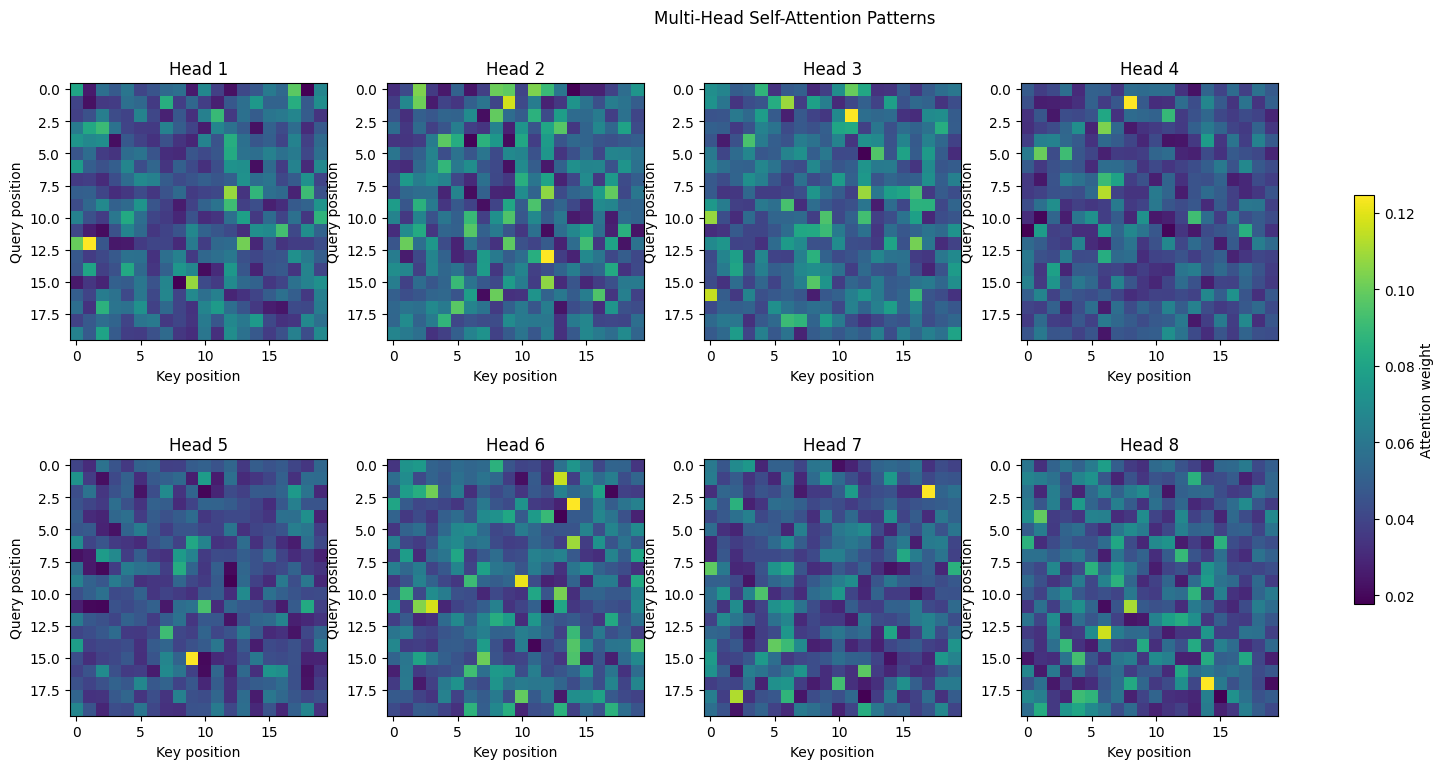

In [14]:
import matplotlib.pyplot as plt

# Create sample data
d_model, num_heads = 256, 8
seq_len = 20

attention = MultiHeadAttention(d_model, num_heads)
attention.eval()

x = torch.randn(1, seq_len, d_model)

# Get attention weights
with torch.no_grad():
    output, attention_weights = attention(x, return_attention_weights=True)

# Plot all 8 heads
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(attention_weights[0, i].numpy(), cmap="viridis")
    ax.set_title(f"Head {i+1}")
    ax.set_xlabel("Key position")
    ax.set_ylabel("Query position")

plt.suptitle("Multi-Head Self-Attention Patterns")
plt.tight_layout()
plt.colorbar(im, ax=axes, shrink=0.6, label="Attention weight")
plt.show()


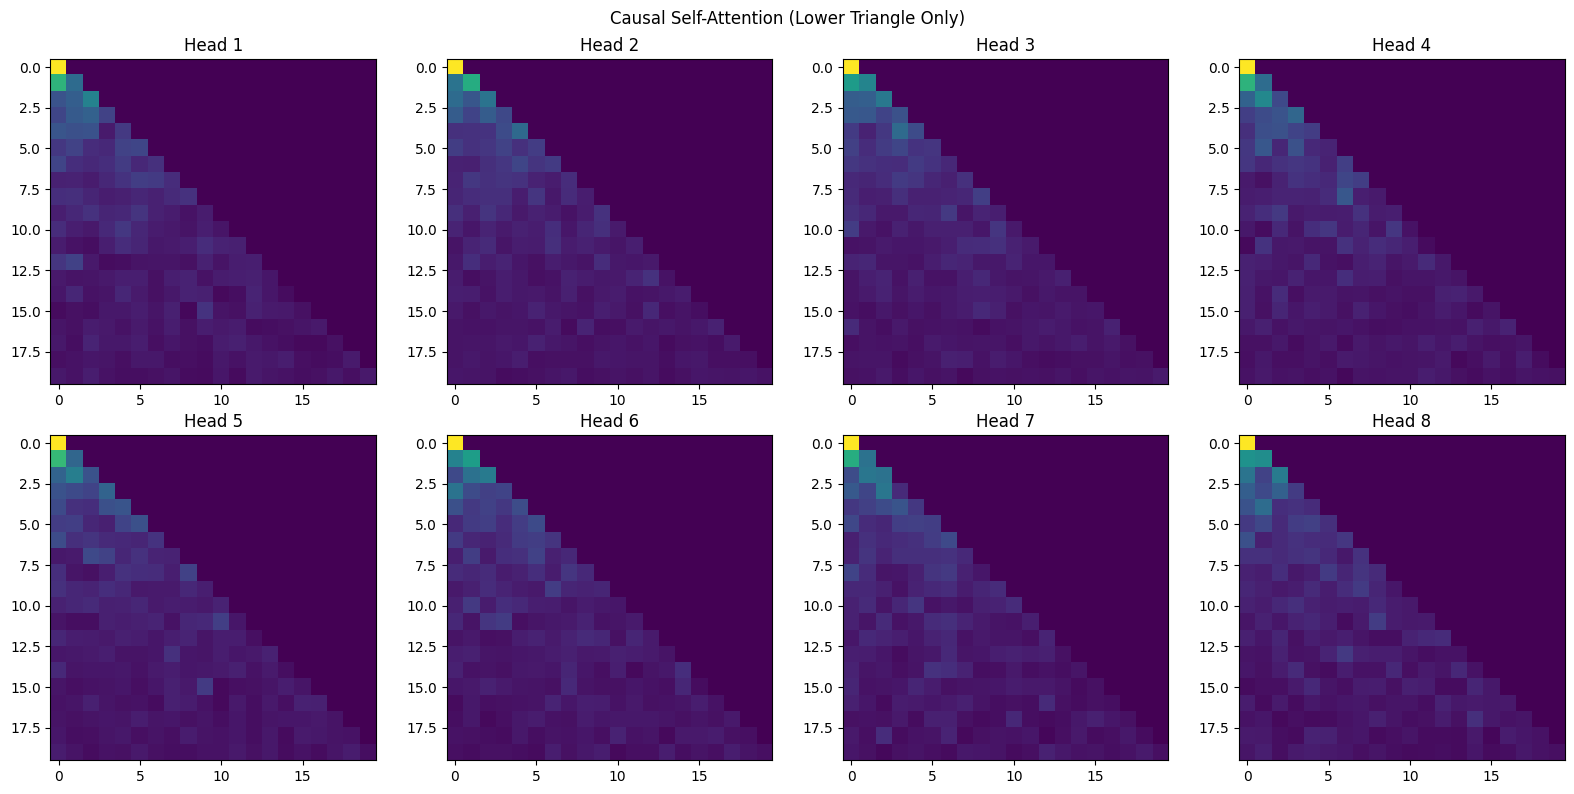

In [ ]:
causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
causal_mask = causal_mask.masked_fill(causal_mask == 1, float("-inf"))
causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    output, attention_weights = attention(
        x, attention_mask=causal_mask, return_attention_weights=True
    )

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(attention_weights[0, i].numpy(), cmap="viridis")
    ax.set_title(f"Head {i+1}")

plt.suptitle("Causal Self-Attention (Lower Triangle Only)")
plt.tight_layout()
plt.show()